In [2]:
!pip install inference_sdk

In [3]:
!pip install colorthief

In [4]:
!pip install mygrad

In [5]:
!pip install webcolors


In [6]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://outline.roboflow.com",
    api_key="sOnMGdZy4C0C5xShlcm0"
)




In [7]:
class Garment:
    def __init__(self, color):
        self.color = color

    def __repr__(self):
        return f"Garment(color={self.color})"

class Image:
    def __init__(self, aesthetic, garments):
        self.garments = garments
        self.aesthetic = aesthetic

    def __repr__(self):
        return f"Image(garment={self.garment})"


In [8]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from skimage.draw import polygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from colorthief import ColorThief


# def get_color(img_path, x, y, w, h, n_colors=1):
#     img = Image.open(img_path)

#     # Crop the image to the bounding box
#     cropped_img = img.crop(((x-w)/2, (y-h)/2, (x + w)/2, (y + h)/2))

#     # Convert image to numpy array
#     img_array = np.array(cropped_img)
#     pixels = img_array.reshape(-1, 3)

#     # Remove alpha channel if present
#     if pixels.shape[1] > 3:
#         pixels = pixels[:, :3]

#     # Use KMeans to find the most common colors
#     kmeans = KMeans(n_clusters=n_colors)
#     kmeans.fit(pixels)

#     # Get the most prominent color
#     colors = kmeans.cluster_centers_
#     labels = kmeans.labels_
#     most_common_color = colors[np.bincount(labels).argmax()]

#     return tuple(most_common_color.astype(int))

def get_color(img_path, coordinates):
    # Load the image
    img = Image.open(img_path)

    # Convert image to numpy array
    img_array = np.array(img)

    # Create a figure and axis
    #fig, ax = plt.subplots()

    # Display the image
    #ax.imshow(img_array)

    # Extract the x and y coordinates
    x_coords = [coord['x'] for coord in coordinates]
    y_coords = [coord['y'] for coord in coordinates]

    #pp = patches.Polygon(xy=list(zip(x_coords, y_coords)), closed=True, edgecolor='red', facecolor='none', linewidth=2)

    # Add the polygon to the plot
    #ax.add_patch(pp)

    # Set the aspect ratio of the plot to be equal
    #ax.set_aspect('equal')

    # Show the plot



    # Create a binary mask
    mask = np.zeros((img_array.shape[0], img_array.shape[1]), dtype=np.uint8)

    # Use the polygon coordinates to create the mask
    rr, cc = polygon(y_coords, x_coords, mask.shape)
    mask[rr, cc] = 1

    polygon_region = np.zeros_like(img_array)
    polygon_region[mask == 1] = img_array[mask == 1]

    # Convert to PIL Image and save
    cropped_img = Image.fromarray(polygon_region)
    cropped_img.save("yessir.jpg")
    #cropped_img.show()

    # Find the most common color
    ct = ColorThief("yessir.jpg")
    palette = ct.get_palette(color_count=2, quality=3)
    #plt.imshow([[palette[i] for i in range(2)]])
    #plt.show()
    #print(palette[1])
    return palette[1]

In [9]:
img_dict = {}
def add_to_dict(img_dict, aesthetic, img_path):
  #print(img_path)
  result = CLIENT.infer(img_path, model_id="deepfashion2-m-11k/1")
  #set dict[count] = Image(make_id_list)
  img_aesthetic = aesthetic
  l = [aesthetic]
  for i in result['predictions']:
    img_garment = i['class']
    #garment_color = get_color(img_path, i['x'], i['y'], i['width'], i['height'])
    garment_color = get_color(img_path, i['points'])
    #print(garment_color)
    g_c = closest_color_name(garment_color)

    l.append(img_garment)
    l.append(g_c)
  img_dict[img_path] = l
  return None

In [10]:
import webcolors
import math

def rgb_to_xyz(rgb):
    r, g, b = [x / 255.0 for x in rgb]
    r = r / 12.92 if r <= 0.04045 else ((r + 0.055) / 1.055) ** 2.4
    g = g / 12.92 if g <= 0.04045 else ((g + 0.055) / 1.055) ** 2.4
    b = b / 12.92 if b <= 0.04045 else ((b + 0.055) / 1.055) ** 2.4
    r, g, b = r * 100, g * 100, b * 100
    x = r * 0.4124564 + g * 0.3575761 + b * 0.1804375
    y = r * 0.2126729 + g * 0.7151522 + b * 0.0721750
    z = r * 0.0193339 + g * 0.1191920 + b * 0.9503041
    return x, y, z

def xyz_to_lab(xyz):
    x, y, z = xyz
    x = x / 95.047
    y = y / 100.000
    z = z / 108.883
    x = x ** (1 / 3) if x > 0.008856 else (x * 7.787 + 16 / 116)
    y = y ** (1 / 3) if y > 0.008856 else (y * 7.787 + 16 / 116)
    z = z ** (1 / 3) if z > 0.008856 else (z * 7.787 + 16 / 116)
    l = max(0, (116 * y) - 16)
    a = max(-128, (x - y) * 500)
    b = max(-128, (y - z) * 200)
    return l, a, b

def delta_e(c1, c2):
    l1, a1, b1 = c1
    l2, a2, b2 = c2
    return math.sqrt((l2 - l1) ** 2 + (a2 - a1) ** 2 + (b2 - b1) ** 2)

def closest_color_name(rgb):
    basic_colors = {
        "red": (230, 0, 0),
        "green": (0, 230, 0),
        "blue": (0, 0, 230),
        "yellow": (230, 230, 0),
        "cyan": (0, 230, 230),
        "magenta": (230, 0, 230),
        "white": (230, 230, 230),
        "black": (0, 0, 0),
        "gray": (110, 110, 110),
        "brown": (140, 100, 0)
        #"silver": (192, 192, 192),
        #"maroon": (128, 0, 0),
        #"olive": (128, 128, 0),
        #"purple": (128, 0, 128),
        #"teal": (0, 128, 128),
        #"navy": (0, 0, 128)
    }

    min_distance = float('inf')
    closest_color = None

    target_xyz = rgb_to_xyz(rgb)
    target_lab = xyz_to_lab(target_xyz)

    for color_name, color_rgb in basic_colors.items():
        color_xyz = rgb_to_xyz(color_rgb)
        color_lab = xyz_to_lab(color_xyz)
        distance = delta_e(target_lab, color_lab)

        if distance < min_distance:
            min_distance = distance
            closest_color = color_name

    return closest_color

# Example usage
#rgb_value = (255, 99, 71)  # Example RGB value
#color_name = closest_color_name(rgb_value)
#print(f"The closest CSS3 basic color is: {color_name}")


In [11]:
def get_new_dict(img_dict):
    big_dict = {}
    for img_path, tup in img_dict.items():
      s = 0 #sum
      for i in tup:
        s += feat_dict[i]
      big_dict[img_path] = s/len(tup)

    return big_dict

In [17]:
import random
import numpy as np

class BaseRecommendationSystem:
    def __init__(self, img_dict, feat_dict):
        self.img_dict = img_dict
        self.feat_dict = feat_dict
        self.prob_dict = self.get_new_dict(img_dict)
    
    def get_new_dict(self, img_dict):
        prob_dict = {}
        for img_path, tup in img_dict.items():
            s = 0  # sum
            for i in tup:
                s += self.feat_dict[i]
            prob_dict[img_path] = s / len(tup)
        return prob_dict

    def get_next_image_path(self):
        raise NotImplementedError("This method should be implemented by subclasses.")
    
    def update_probabilities(self, img_path, feedback):
        raise NotImplementedError("This method should be implemented by subclasses.")

class HeuristicRecommendationSystem(BaseRecommendationSystem):
    def __init__(self, img_dict, feat_dict):
        super().__init__(img_dict, feat_dict)

    def get_next_image_path(self):
        keys = list(self.prob_dict.keys())
        vals = list(self.prob_dict.values())
        l = range(len(vals))
        i = random.choices(l, weights=vals, k=1)[0]
        return keys[i]

    def update_probabilities(self, img_path, feedback):
        attribute_list = self.img_dict[img_path]
        if feedback.lower() == 'upvote':
            for a in attribute_list:
                self.feat_dict[a] += 2 * self.feat_dict[a]
        else:
            for a in attribute_list:
                self.feat_dict[a] -= 2/3 * self.feat_dict[a]
        self.prob_dict = self.get_new_dict(self.img_dict)

class EpsilonGreedyRecommendationSystem(BaseRecommendationSystem):
    def __init__(self, img_dict, feat_dict, epsilon=0.1):
        super().__init__(img_dict, feat_dict)
        self.epsilon = epsilon
        self.seen_images = set()

    def calculate_image_score(self, img_path):
        attribute_list = self.img_dict[img_path]
        scores = [self.feat_dict[a] for a in attribute_list]
        return np.mean(scores)

    def get_next_image_path(self):
        keys = list(self.prob_dict.keys())
        if random.random() < self.epsilon:  # Exploration
            choices = [k for k in keys if k not in self.seen_images]
            if not choices:  # If all images have been seen
                choices = keys
            selected_image = random.choice(choices)
        else:  # Exploitation
            best_image = None
            best_score = -float('inf')
            for img_path in keys:
                if img_path not in self.seen_images:
                    image_score = self.calculate_image_score(img_path)
                    if image_score > best_score:
                        best_score = image_score
                        best_image = img_path
            selected_image = best_image if best_image else random.choice(keys)
        
        self.seen_images.add(selected_image)
        return selected_image

    def update_probabilities(self, img_path, feedback):
        attribute_list = self.img_dict[img_path]
        if feedback.lower() == 'upvote':
            reward = 2
        else:
            reward = -2/3
        
        for a in attribute_list:
            self.feat_dict[a] += reward * self.feat_dict[a]
        
        self.prob_dict = self.get_new_dict(self.img_dict)


In [13]:
import matplotlib.image as mpimg

In [21]:
# adding all the values to our dictionary of images
from mygrad.nnet import softmax

# aesthetic dict

a_dict = {name: 0.4 for name in ["athleisure", "coquette", "grunge", "bohemian", "minimalist", "streetwear"]}

# top dict
t_dict = {cloth: 0.25 for cloth in ['short sleeve top', 'long sleeve top', 'short sleeve outwear', 'long sleeve outwear', 'vest', 'sling', 'short sleeve dress', 'long sleeve dress', 'vest dress', 'sling dress']}

# bottom dict
b_dict = {pant: 0.2 for pant in ['shorts', 'trousers', 'skirt']}

# color dict
c_dict = {"red": 0.05,
        "green": 0.05,
        "blue": 0.05,
        "yellow": 0.05,
        "cyan": 0.05,
        "magenta": 0.05,
        "white": 0.05,
        "black": 0.05,
        "gray": 0.05,
        "brown": 0.05}

feat_dict = {}
feat_dict.update(a_dict)
feat_dict.update(t_dict)
feat_dict.update(b_dict)
feat_dict.update(c_dict)

#print(feat_dict)



In [15]:
#from PIL import Image
#img_path = "sporty1.jpg"
#image = Image.open(img_path)
#image.show()

# adding all the values to our dictionary of images

#for i in range(25):
    #add_to_dict(img_dict, "bohemian", f"boh-{i + 1}.jpg")

for i in range(25):
    add_to_dict(img_dict, "grunge", f"gru-{i + 1}.jpg")

for i in range(50):
    add_to_dict(img_dict, "athleisure", f"sporty-{i + 1}.jpg")

for i in range(50):
    add_to_dict(img_dict, "coquette", f"coquette-{i + 1}.jpg")

for i in range(50):
    add_to_dict(img_dict, "minimalist", f"minimalist-{i + 1}.jpg")

for i in range(50):
    add_to_dict(img_dict, "streetwear", f"streetwear-{i + 1}.jpg")

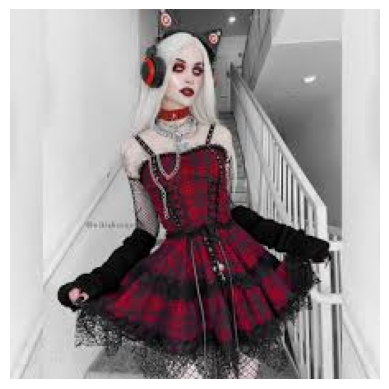

Enter upvote/downvote/satisfied  ->  upvote


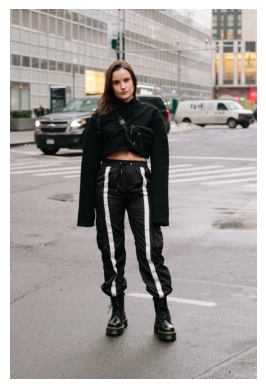

Enter upvote/downvote/satisfied  ->  upvote


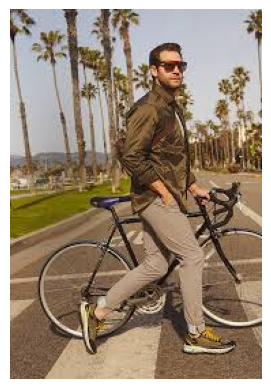

Enter upvote/downvote/satisfied  ->  upvote


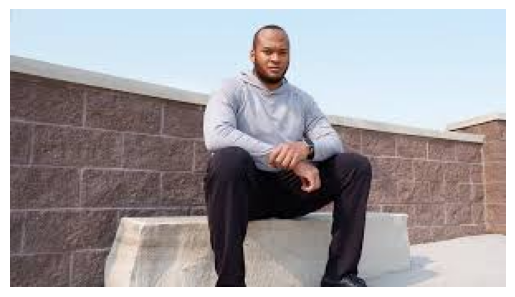

Enter upvote/downvote/satisfied  ->  downvote


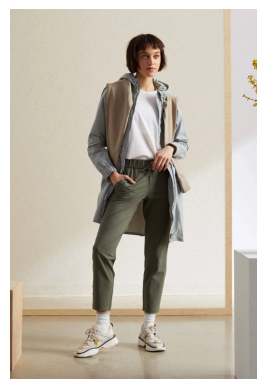

In [ ]:
# Choose the algorithm
RECOMMENDATION_SYSTEM_SWITCH = 2  # 1 for Heuristic, 2 for Epsilon-Greedy

if RECOMMENDATION_SYSTEM_SWITCH == 1:
    recommender = HeuristicRecommendationSystem(img_dict, feat_dict)
elif RECOMMENDATION_SYSTEM_SWITCH == 2:
    recommender = EpsilonGreedyRecommendationSystem(img_dict, feat_dict, epsilon=0.1)

# Use the recommendation system
#next_image = recommender.get_next_image_path()
#recommender.update_probabilities(next_image, 'upvote')

is_satisfied = False

prob_dict = {}
img_p = ''


while is_satisfied == False:
  prob_dict = get_new_dict(img_dict)
  img_p = recommender.get_next_image_path()

  img = mpimg.imread(img_p)
  # fig, ax = plt.subplots()
  # ax.imshow(img)
  # ax.axis('off')
  plt.imshow(img)
    # Create a figure and axis
  plt.axis('off')

    # Display the image

  plt.show(block=False)
  plt.pause(1)
  ans = input("Enter upvote/downvote/satisfied  ->  ")
  if (ans == 'satisfied'):
    print('done')
    break
  else:
    recommender.update_probabilities(img_p, 'upvote')
